# Topic modeling with (word embeding + K-mean) and LDA
The idea of this notebook is to test two different methode for topic modeling:
    - Word embeding for sentence vectorization couple with k-mean clustering algorithm.
    - Latent Dirichlet Allocation (LDA)
    
We will also see if the two methode help to provide roughly the smae document partitioning.

We will additionnaly observe two other intersting points of word embeding.

The Data we will use are news headlines from the austrelian news service ABC News. You can find the full dataset on kaggle following the following [link](https://www.kaggle.com/therohk/million-headlines).

## Imports

In [ ]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models import KeyedVectors
from gensim import corpora, models

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from tqdm import tqdm
tqdm.pandas()

## Data loading

In [6]:
raw_headlines = pd.read_csv('../../data/abcnews-date-text.csv',parse_dates=[0], infer_datetime_format=True)
raw_headlines.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


## Data visualisation

### Number of words per headlines

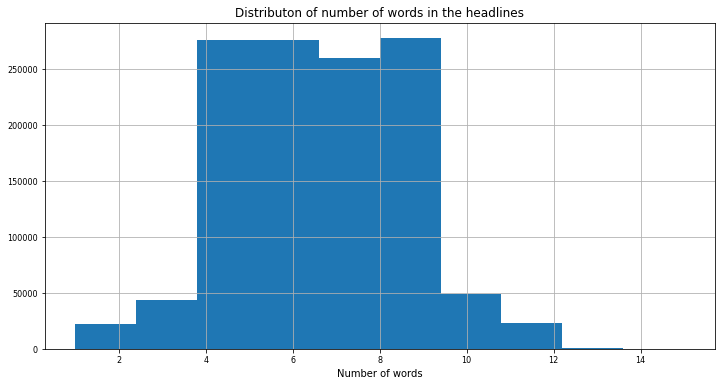

In [7]:
raw_headlines['NumWords'] = raw_headlines['headline_text'].apply(lambda x: len(x.split()))
raw_headlines[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the headlines")
plt.xlabel("Number of words")
plt.show()

### Distribution of the data accross time

In [8]:
raw_headlines['year'] = pd.DatetimeIndex(raw_headlines['publish_date']).year
raw_headlines['month'] = pd.DatetimeIndex(raw_headlines['publish_date']).month
raw_headlines['day'] = pd.DatetimeIndex(raw_headlines['publish_date']).day

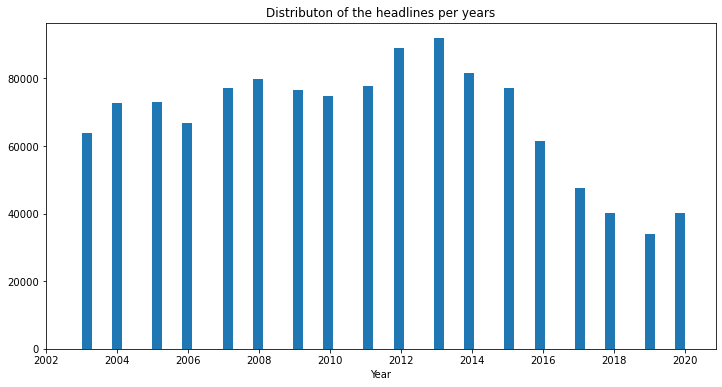

In [9]:
plt.figure(figsize=(12, 6))
plt.hist(raw_headlines['year'], bins=60);
plt.title("Distributon of the headlines per years")
plt.xlabel("Year")
plt.xticks([x for x in range(2002, 2021, 2)], [x for x in range(2002, 2021, 2)])
plt.show()

##### Observation:
The headlines are fairly well distributed across the years from 2002 to 2020

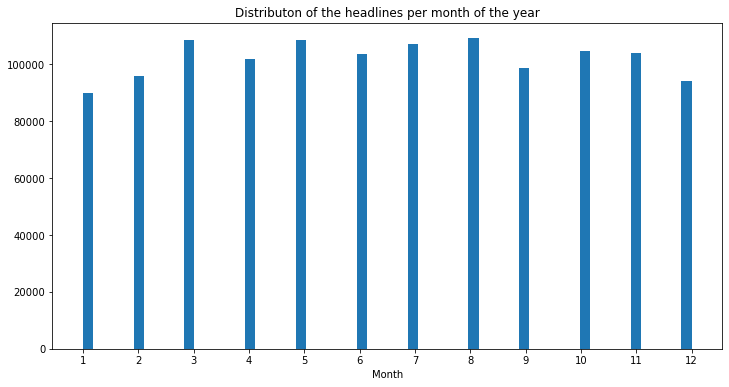

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(raw_headlines['month'], bins=60);
plt.title("Distributon of the headlines per month of the year")
plt.xlabel("Month")
plt.xticks([x for x in range(1, 13)], [x for x in range(1, 13)])
plt.show()

##### Observation:
The headlines are fairly well distributed across the month of the year.

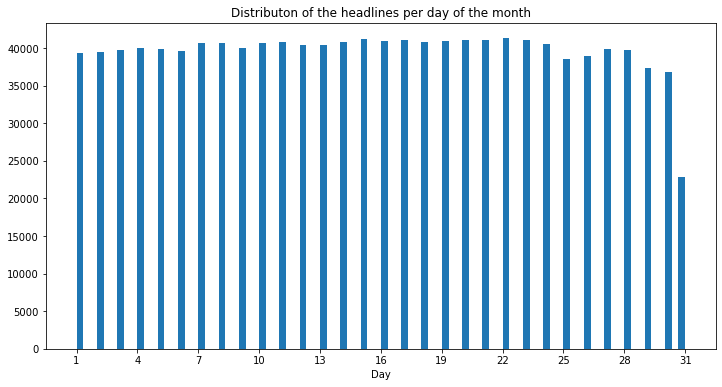

In [11]:
plt.figure(figsize=(12, 6))
plt.hist(raw_headlines['day'], bins=90);
plt.title("Distributon of the headlines per day of the month")
plt.xlabel("Day")
plt.xticks([x for x in range(1, 32, 3)], [x for x in range(1, 32, 3)])
plt.show()

##### Observation:
The headlines are fairly well distributed across the days of the month. Obviously twice less on the 31st as it only happpen every other month.

### Word cloud  

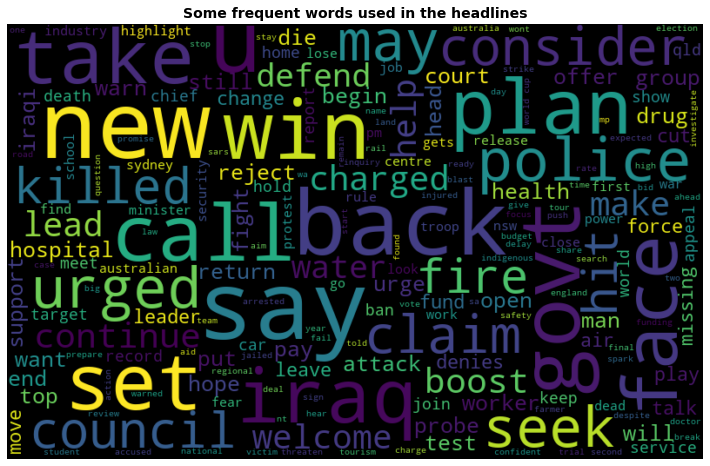

In [12]:
from wordcloud import WordCloud
all_words = ''.join([word for word in raw_headlines['headline_text'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the headlines", weight='bold', fontsize=14)
plt.show()

## Data preprocessing

In [23]:
headlines = raw_headlines.copy()

#### Remove non alpha numeric characters, lower case the headlines and apply lemmatization:

In [24]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')

def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    lemmatized = " ".join([WordNetLemmatizer().lemmatize(w, get_wordnet_pos(t))\
                  for w, t in  nltk.pos_tag(nltk.word_tokenize(lower))])
    
    no_punctuation = NON_ALPHANUM.sub(r' ', lemmatized)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
headlines['headline_text'] = headlines['headline_text'].progress_apply(normalize_texts)
headlines.head()

#Lemmatization
lemmatizer = WordNetLemmatizer()
headlines['headline_text'] = headlines['headline_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=2]))

100%|██████████| 1226258/1226258 [13:52<00:00, 1473.31it/s]


#### We save the current state of the dataset as the processing is rather long

In [27]:
# headlines.to_csv("../../data/lemmatized_headlines.csv", index=False)
# headlines = pd.read_csv("../../data/lemmatized_headlines.csv")

In [28]:
print(headlines.shape)
headlines.head()

(1226258, 6)


,publish_date,headline_text,NumWords,year,month,day
0,2003-02-19,aba decides against community broadcasting lic...,6,2003,2,19
1,2003-02-19,act fire witness must be aware of defamation,8,2003,2,19
2,2003-02-19,call for infrastructure protection summit,7,2003,2,19
3,2003-02-19,air nz staff in aust strike for pay rise,9,2003,2,19
4,2003-02-19,air nz strike to affect australian traveller,7,2003,2,19


In [29]:
print(raw_headlines.shape)
raw_headlines.head()

(1226258, 6)


,publish_date,headline_text,NumWords,year,month,day
0,2003-02-19,aba decides against community broadcasting lic...,6,2003,2,19
1,2003-02-19,act fire witnesses must be aware of defamation,8,2003,2,19
2,2003-02-19,a g calls for infrastructure protection summit,7,2003,2,19
3,2003-02-19,air nz staff in aust strike for pay rise,9,2003,2,19
4,2003-02-19,air nz strike to affect australian travellers,7,2003,2,19


## First methode (Word2Vec + K-means):
Apply word2vec on our textual data and use k-means as clustering algorithm.

### Load of the pretrained word2vec

We are using the pre-trained word2vec GoogleNews-vectors-negative300 with continuous bag-of-words and skip-gram architecture. It was trained by google on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The full details on the word2vec algorithm can be found [here](https://code.google.com/archive/p/word2vec/).

In [30]:
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

#### Word embeding o the word news

In [31]:
word = 'news'
print('Word: {}'.format(word))
print('First 20 values of embedding:\n{}'.format(word2vec[word][:20]))

Word: news
First 20 values of embedding:
[-0.13867188  0.04370117 -0.13085938 -0.16796875 -0.06054688 -0.07080078
  0.00854492 -0.09960938  0.19628906  0.14648438 -0.23046875 -0.09619141
 -0.140625    0.25585938 -0.16699219  0.14257812 -0.16992188  0.06884766
  0.23925781 -0.28515625]


##### Interesting aspect of word embeding number 1 :
You can use word embeding for word trasnlation. For example when you compute the vector word2vec("woman") + (word2vec("king") - word2vec("man")), you obtain a vector pretty close to the vector word2vec("queen").
Similarly, when you compute the vector word2vec("Tennis") + (word2vec("Ronaldo") - word2vec("Soccer")), you obtain a vector pretty close to the vector word2vec("Nadal").

In [32]:
print(word2vec.most_similar(positive=['woman', 'king'], negative=['man'], topn=3))
print(word2vec.most_similar(positive=['Tennis', 'Ronaldo'], negative=['Soccer'], topn=3))

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951)]
[('Nadal', 0.6514424681663513), ('Safin', 0.6181676983833313), ('Federer', 0.6156208515167236)]


### Application of the word2vec to our dataset

In [117]:
headlines_smaller = pd.DataFrame(headlines[headlines.year < 2020]['headline_text']).sample(frac = 0.2, random_state= 423)
headlines_smaller.columns = ['head_line']
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])
#representing each headline by the mean of word embeddings for the words used in the headlines.
wtv_vect = WordVecVectorizer(word2vec)
headlines_wtv = wtv_vect.transform(headlines_smaller.head_line)
print(headlines_wtv.shape)

(237204, 300)


##### Interesting aspect of word embeding number 2:
You can look for a topic in your headlines data set useing word embeding. You should apply word2vec to your topic and compute the average word2vec of each headlines. If you then compute the scallar product between your vectorised toopic and your vectorised headline, you will then obtain a score of similarity. Indeed the more similare are the vector, the higher are their scallar product. Then sellect the top headlines based on your similarity score.

Let's try with the word "energy".

In [118]:
energy_wtv = wtv_vect.transform(["energy"])
energy_wtv[:,:10]

array([[-0.10351562,  0.16113281,  0.1171875 , -0.25390625,  0.00891113,
         0.00823975,  0.10302734, -0.40039062,  0.09423828,  0.03063965]],
      dtype=float32)

In [119]:
top_10_energy_headlines = sorted(list(enumerate(headlines_wtv.dot(energy_wtv.T))), key=lambda x: -x[1][0])[:10]

In [120]:
raw_headlines.loc[headlines_smaller.iloc[[i for i, score in top_10_energy_headlines]].index]

,publish_date,headline_text,NumWords,year,month,day
831499,2013-11-04,renewable energy mildura,3,2013,11,4
1102201,2017-10-12,renewable energy baseload power,4,2017,10,12
917179,2014-11-18,riverina solar,2,2014,11,18
1003801,2016-01-07,wumbulgul solar,2,2016,1,7
746704,2012-12-06,simplot clean energy,3,2012,12,6
660272,2011-12-15,renewable energy fund,3,2011,12,15
874699,2014-05-16,cfmeu wollongong coal,3,2014,5,16
684450,2012-04-02,moolarben coal,2,2012,4,2
737303,2012-11-01,whitehaven coal,2,2012,11,1
1166872,2019-06-06,solar renewable power energy farm,5,2019,6,6


##### *Observation*:
You can of course find some headlines with the word "energy" in it, but also some without. This is the case for "wumbulgul solar" or "moolarben coal" wich are totaly relevent in our case.

In [122]:
print(headlines_smaller.shape)
headlines_smaller.head()

(237204, 1)


,head_line
234120,council to crack down on disabled parking breach
437688,no recession nsw premier nathan rees talk to abc
710677,the finance quarter
1096788,middle east leader unsure of trumps foreign po...
1057082,news exchange 10th november


### Application of the K-mean algorithm
As usuall it is hard to find the perfect number k of cluster. In our case we will go for 8.

In [123]:
km = KMeans(
    n_clusters=12, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(headlines_wtv)
df_km = pd.DataFrame({'headlines' :headlines_smaller.head_line, 'km_topic' :y_km })

In [148]:
print(f"Silhouettte score : ", silhouette_score(headlines_wtv[::10], y_km[::10]))

Silhouettte score :  0.002897210088995135


##### *Observation*:
The silhouette score is not verry big, but in topic modeling the cluster are usually not very distinct which is not verry worrying.

In [124]:
df_km.head()

,headlines,km_topic
234120,council to crack down on disabled parking breach,4
437688,no recession nsw premier nathan rees talk to abc,0
710677,the finance quarter,3
1096788,middle east leader unsure of trumps foreign po...,4
1057082,news exchange 10th november,0


### Topic top words analysis
In this part we look at the most frequent words per topic. However we removed the word which appear in the top 20 of more then 3 topics as we thought they were less discriminative.

In [125]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.2, min_df=2).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [126]:
top_20s = []
top_20s_word_count = {}
for tc in sorted(df_km.km_topic.unique()):
    new_top_20 = get_top_n_words(df_km[df_km.km_topic == tc].headlines.values, n=20)
    top_20s.append(new_top_20)
    for w, _ in new_top_20:
        if w in top_20s_word_count.keys():
            top_20s_word_count[w] += 1
        else:
            top_20s_word_count[w] = 1

for tc, top_20 in enumerate(top_20s):
    print(f"Topic #{tc} :")
    print([(w, c) for w, c in top_20 if top_20s_word_count.get(w, 0) < 3][:10])

Topic #0 :
[('australia', 1373), ('abc', 762), ('01', 725), ('australian', 660), ('sydney', 628), ('country', 508), ('hour', 502), ('country hour', 497), ('england', 365), ('drum', 340)]
Topic #1 :
[('flood', 1278), ('water', 1030), ('rain', 723), ('storm', 697), ('bushfire', 695), ('coast', 603), ('cyclone', 553), ('south', 494), ('blaze', 487), ('hit', 486)]
Topic #2 :
[('farmer', 1346), ('farm', 600), ('grower', 574), ('cattle', 426), ('crop', 404), ('dairy', 378), ('rural', 356), ('grain', 318), ('harvest', 302), ('drought', 253)]
Topic #3 :
[('market', 1455), ('price', 1161), ('rise', 1058), ('rate', 1027), ('share', 645), ('boost', 555), ('high', 545), ('profit', 502), ('industry', 488), ('business', 472)]
Topic #4 :
[('council', 3061), ('plan', 2291), ('govt', 1861), ('urge', 1224), ('government', 1173), ('health', 1135), ('election', 955), ('fund', 932), ('minister', 920), ('union', 869)]
Topic #5 :
[('charge', 2205), ('murder', 2125), ('court', 2085), ('jail', 1686), ('police'

##### *Observation*:
The topic seems to make sens when we look at the top words of each one of them. We could give them the following titles:
- Topic \#0: Local news (not as good as the others)
- Topic \#1: Weather and natural disasters
- Topic \#2: Farming
- Topic \#3: Economy
- Topic \#4: Politics
- Topic \#5: Crimes
- Topic \#6: Education (not as good as the others)
- Topic \#7: Car accident
- Topic \#8: Athlete interviews
- Topic \#9: war and foreign politics
- Topic \#10: Sports
- Topic \#11: Animals

## Second methode (LDA):
Latent Dirichlet allocation is one of the most common algorithms for topic modeling. Without diving into the math behind the model, we can understand it as being guided by two principles:

- Every document is a mixture of topics. We imagine that each document may contain words from several topics in particular proportions. For example, in a two-topic model we could say “Document 1 is 90% topic A and 10% topic B, while Document 2 is 30% topic A and 70% topic B.”
- Every topic is a mixture of words. For example, we could imagine a two-topic model of American news, with one topic for “politics” and one for “entertainment.” The most common words in the politics topic might be “President”, “Congress”, and “government”, while the entertainment topic may be made up of words such as “movies”, “television”, and “actor”. Importantly, words can be shared between topics; a word like “budget” might appear in both equally.

LDA is a mathematical method for estimating both of these at the same time: finding the mixture of words that is associated with each topic, while also determining the mixture of topics that describes each document.


### Data subsampling
As LDA work with TF-IDF, the vecetors representing the documents are much bigger than with word2vec. Therefore we need to reduce the size of our dataset.

In [127]:
df_lda = df_km.sample(frac = 0.1, random_state= 423)[["headlines"]]
df_lda.shape

(23720, 1)

In [128]:
df_lda.head()

,headlines
358920,germany to honour minogue
145607,supersub owen rescue real
544836,surgery end nicoskis season
379038,grandchild of iron ore magnate win million
46188,budget surplus should go to roads local govt


### Preprocessing:
Vectorization of the headlines with using TF-IDF. We will consider n-gram from 1 to 3. We will also ignore words which appear in more than 10% of the headlines and in less than 2 documents. 
We know that LDA [paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) indicate to use bag of word, but the topic modeling provided better results with this methode.

In [181]:
bow_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000, ngram_range=(1, 2), max_df=0.2, min_df=2)
headlines_matrix = bow_vectorizer.fit_transform(df_lda['headlines'])
headlines_matrix.shape

(23720, 15377)

##### Observation:
As we can see the vector representing one headline is of dimension 16714, which is much bigger than what we had with word2vec (300).

### Modeling:
Just like with the k-means algorithm, LDA need to know the number of clusters requiered. In our case we will use 8 again. (We used the number of topics which provided the best silhouette score.

In [182]:
# This cell can take a few minutes to run.
lda = LatentDirichletAllocation(n_components=12, learning_method='online', 
                                random_state=42, verbose=0, n_jobs=-1)
lda_model = lda.fit(headlines_matrix)
lda_matrix = lda_model.transform(headlines_matrix)
print(lda_matrix.shape)
lda_matrix
print(f"Silhouettte score : ", silhouette_score(headlines_matrix, lda_matrix.argmax(axis=1)))

(23720, 12)
Silhouettte score :  -0.002806285091133611


In [183]:
df_lda["lda_topic"] = lda_matrix.argmax(axis=1)
df_lda["probability_lda_topic"] = lda_matrix.max(axis=1)

In [185]:
df_lda.head()

,headlines,lda_topic,probability_lda_topic
358920,germany to honour minogue,0,0.276517
145607,supersub owen rescue real,0,0.285907
544836,surgery end nicoskis season,6,0.663851
379038,grandchild of iron ore magnate win million,7,0.470745
46188,budget surplus should go to roads local govt,8,0.611823


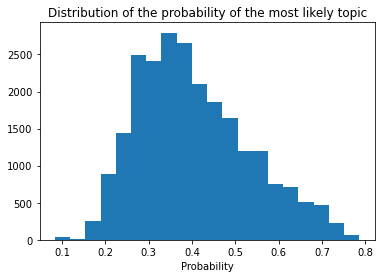

In [186]:
plt.hist(df_lda.probability_lda_topic, bins=20)
plt.title("Distribution of the probability of the most likely topic")
plt.xlabel("Probability")
plt.show()

##### *Observation*:
As we said, each headline is from a mixture of topic. Therefor the resulting vector for each headline is a 12 dimension vector of values between 0 and 1 describing the probability of belonging to a given topic. We can then understand that in some case the model will be more confident to attribute a topic to a document than others. For example the headline "supersub owen rescue real" is attributed to the cluster 0 but with pretty low confidence. As we can see in the distribution plot, most headlines are verry likely to belong to more than one topic.

### Topics analysis
Let's now display the top 10 word of each topics.

In [188]:
top_20s = []
top_20s_word_count = {}
for tc in sorted(df_lda.lda_topic.unique()):
    new_top_20 = get_top_n_words(df_lda[df_lda.lda_topic == tc].headlines.values, n=20)
    top_20s.append(new_top_20)
    for w, _ in new_top_20:
        if w in top_20s_word_count.keys():
            top_20s_word_count[w] += 1
        else:
            top_20s_word_count[w] = 1

for tc, top_20 in enumerate(top_20s):
    print(f"Topic #{tc} :")
    print([(w, c) for w, c in top_20 if top_20s_word_count.get(w, 0) < 4][:10])

Topic #0 :
[('man', 100), ('driver', 81), ('charge', 77), ('centre', 63), ('crash', 61), ('guilty', 53), ('hospital', 47), ('park', 46), ('melbourne', 46), ('plead', 46)]
Topic #1 :
[('child', 95), ('sex', 66), ('government', 49), ('boost', 46), ('lead', 46), ('hit', 38), ('vote', 36), ('abuse', 35), ('year', 34), ('review', 31)]
Topic #2 :
[('price', 72), ('rate', 59), ('rise', 49), ('open', 45), ('fall', 43), ('road', 39), ('share', 39), ('help', 32), ('long', 31), ('hit', 30)]
Topic #3 :
[('health', 109), ('green', 77), ('fund', 74), ('election', 74), ('labor', 71), ('service', 68), ('public', 60), ('tax', 57), ('report', 57), ('arrest', 49)]
Topic #4 :
[('interview', 119), ('rural', 107), ('water', 105), ('nsw', 83), ('north', 64), ('home', 62), ('national', 62), ('qld', 62), ('south', 61), ('school', 58)]
Topic #5 :
[('man', 132), ('court', 104), ('accuse', 104), ('sydney', 91), ('face', 90), ('car', 83), ('woman', 81), ('murder', 76), ('death', 67), ('charge', 67)]
Topic #6 :
[('

##### *Observation*:
The topics seems to make sense again. For example Topic 0 seems to be about car accident, topic 3 is about politics and topic 6 seems to be about crimes. But overall the topics don't seems to be as good and defined when looking at the top 10 words. The silhouette score was also not as good as the k-mean clustering one.

### Topics separation visualisation
In order to see how well separeted are our topics, we will display our documents in 2 dimensions. In order to do so we will use the t-SNE algorithm (t-Distributed Stochastic Neighbor Embedding).

t-SNE  is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. For more information, you can go to  the following [link](https://lvdmaaten.github.io/tsne/).

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 23720 samples in 0.043s...
[t-SNE] Computed neighbors for 23720 samples in 8.753s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23720
[t-SNE] Computed conditional probabilities for sample 2000 / 23720
[t-SNE] Computed conditional probabilities for sample 3000 / 23720
[t-SNE] Computed conditional probabilities for sample 4000 / 23720
[t-SNE] Computed conditional probabilities for sample 5000 / 23720
[t-SNE] Computed conditional probabilities for sample 6000 / 23720
[t-SNE] Computed conditional probabilities for sample 7000 / 23720
[t-SNE] Computed conditional probabilities for sample 8000 / 23720
[t-SNE] Computed conditional probabilities for sample 9000 / 23720
[t-SNE] Computed conditional probabilities for sample 10000 / 23720
[t-SNE] Computed conditional probabilities for sample 11000 / 23720
[t-SNE] Computed conditional probabilities for sample 12000 / 23720
[t-SNE] Computed conditional probabilities for sa

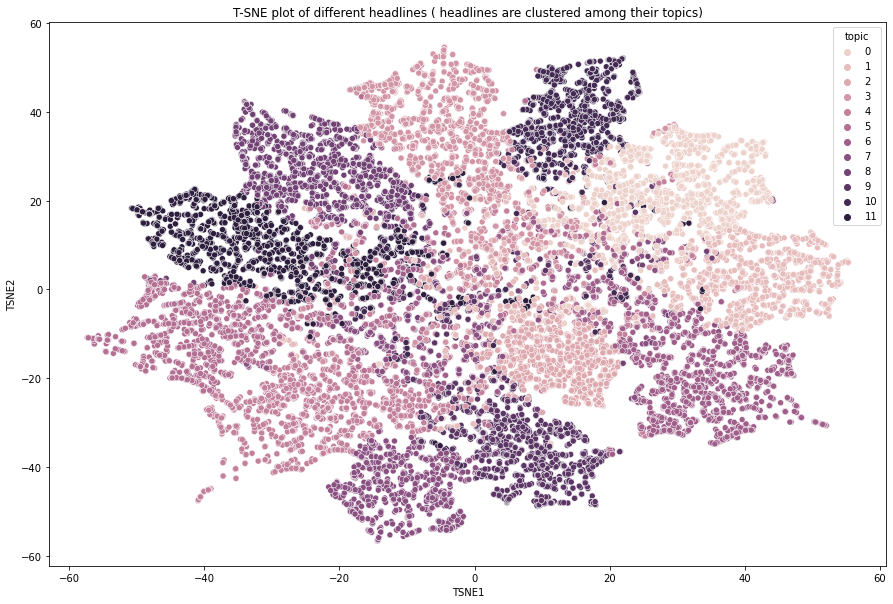

In [189]:
model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_features = model.fit_transform(lda_matrix)
df_lda_tsne = pd.DataFrame(tsne_features)
df_lda_tsne['topic'] = lda_matrix.argmax(axis=1)
df_lda_tsne.columns = ['TSNE1', 'TSNE2', 'topic']

plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of different headlines ( headlines are clustered among their topics)')
ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df_lda_tsne, legend = 'full')
plt.show()

## Model results comparison
We merge the two dataframe with topics from the two methode to see if they predict similar topics.

In [190]:
df_lda.head()

,headlines,lda_topic,probability_lda_topic
358920,germany to honour minogue,0,0.276517
145607,supersub owen rescue real,0,0.285907
544836,surgery end nicoskis season,6,0.663851
379038,grandchild of iron ore magnate win million,7,0.470745
46188,budget surplus should go to roads local govt,8,0.611823


In [191]:
compareason_matrix = df_km.merge(df_lda, on="headlines")
compareason_matrix.head()

,headlines,km_topic,lda_topic,probability_lda_topic
0,council to crack down on disabled parking breach,4,7,0.283305
1,the finance quarter,3,8,0.473595
2,the finance quarter,3,8,0.473595
3,the finance quarter,3,8,0.473595
4,the finance quarter,3,8,0.473595


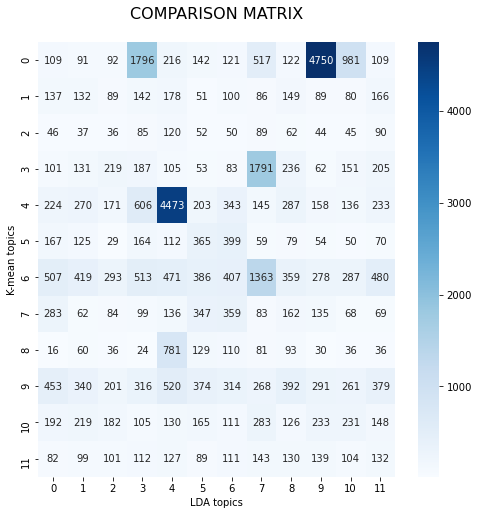

In [192]:

conf_mat = confusion_matrix(compareason_matrix["km_topic"], compareason_matrix["lda_topic"])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('K-mean topics')
plt.xlabel('LDA topics')
plt.title("COMPARISON MATRIX\n", size=16);


##### *Observation*:

What we can see is that some cluster are shared between the two techniques. In particular, the topics 3 and 9 from LDA is really linked to the topic 0 of k-means. The topic 4 with LDA is linked to the topic 4 of k-means. And finally the topic 7 of LDA is linked to the topics 3 and 6 of k-means.

## Sepcial case of 2020
What we have seen in the from the previous analysis is that we managed to capture the general topic of the new headlines like politics, crimes, car accidents. But with 2020, some specific event could have modify the topics of the news and create some trendy one.

In [199]:
headlines_2020_df = raw_headlines[raw_headlines.year == 2020]
print(headlines_2020_df.shape)
headlines_2020_df.head()

(40240, 6)


,publish_date,headline_text,NumWords,year,month,day
1186018,2020-01-01,a new type of resolution for the new year,9,2020,1,1
1186019,2020-01-01,adelaide records driest year in more than a de...,9,2020,1,1
1186020,2020-01-01,adelaide riverbank catches alight after new ye...,9,2020,1,1
1186021,2020-01-01,adelaides 9pm fireworks spark blaze on riverbank,7,2020,1,1
1186022,2020-01-01,archaic legislation governing nt women propert...,7,2020,1,1


In [204]:
headlines_2020_lda_df = headlines_2020_df.sample(frac = 0.5, random_state= 423)

In [233]:
tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000, ngram_range=(1, 3), max_df=0.2, min_df=2)
headlines_2020_matrix = tf_vectorizer.fit_transform(headlines_2020_lda_df['headline_text'])
headlines_2020_matrix.shape

(20120, 21012)

In [246]:
# This cell can take a few minutes to run.
lda = LatentDirichletAllocation(n_components=6, learning_method='online',
                                          random_state=42, verbose=0, n_jobs = -1)
lda_model = lda.fit(headlines_2020_matrix)
lda_matrix = lda_model.transform(headlines_2020_matrix)
print(lda_matrix.shape)
lda_matrix

(20120, 6)


array([[0.04220554, 0.04220721, 0.04222824, 0.04218939, 0.78898024,
        0.04218938],
       [0.04864343, 0.04864328, 0.46019047, 0.04864328, 0.34523628,
        0.04864326],
       [0.05246534, 0.46980831, 0.05202624, 0.05202652, 0.05202648,
        0.32164711],
       ...,
       [0.05582728, 0.0565188 , 0.22070144, 0.55485789, 0.05626733,
        0.05582726],
       [0.04658721, 0.55344254, 0.13286875, 0.04658766, 0.17388364,
        0.04663019],
       [0.34156136, 0.21115433, 0.23496886, 0.04220524, 0.04234522,
        0.12776499]])

In [247]:
headlines_2020_lda_df["lda_topic"] = lda_matrix.argmax(axis=1)
headlines_2020_lda_df["probability_lda_topic"] = lda_matrix.max(axis=1)

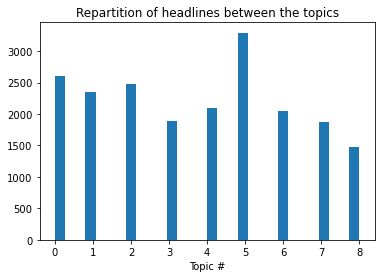

In [255]:
plt.title("Repartition of headlines between the topics")
plt.hist(headlines_2020_lda_df["lda_topic"], bins=30)
plt.xlabel("Topic #")
plt.show()

In [249]:
top_20s = []
top_20s_word_count = {}
for tc in sorted(headlines_2020_lda_df.lda_topic.unique()):
    new_top_20 = get_top_n_words(headlines_2020_lda_df[headlines_2020_lda_df.lda_topic == tc].headline_text.values, n=20)
    top_20s.append(new_top_20)
    for w, _ in new_top_20:
        if w in top_20s_word_count.keys():
            top_20s_word_count[w] += 1
        else:
            top_20s_word_count[w] = 1

for tc, top_20 in enumerate(top_20s):
    print(f"Topic #{tc} :")
    print([(w, c) for w, c in top_20 if top_20s_word_count.get(w, 0) < 3][:10])

Topic #0 :
[('scott', 113), ('morrison', 110), ('drum', 110), ('health', 98), ('quarantine', 98), ('andrews', 95), ('hotel', 95), ('scott morrison', 94), ('says', 88), ('finance', 86)]
Topic #1 :
[('restrictions', 252), ('cases', 201), ('coronavirus cases', 145), ('coronavirus restrictions', 125), ('wa', 125), ('says', 109), ('melbourne', 107), ('lockdown', 97), ('tasmania', 92), ('nt', 90)]
Topic #2 :
[('trump', 359), ('donald', 245), ('donald trump', 238), ('border', 214), ('live', 178), ('news', 178), ('election', 171), ('biden', 164), ('covid19', 164), ('china', 143)]
Topic #3 :
[('afl', 149), ('nrl', 115), ('court', 102), ('open', 87), ('crash', 83), ('melbourne', 79), ('year', 77), ('brisbane', 76), ('rain', 75), ('final', 72)]
Topic #4 :
[('pandemic', 128), ('government', 111), ('cases', 111), ('coast', 105), ('amid', 104), ('federal', 83), ('budget', 78), ('bushfire', 77), ('black', 73)]
Topic #5 :
[('sydney', 144), ('briefing', 119), ('aged', 109), ('care', 106), ('south', 97)

#### *Observations*:
With 6 topics, LDA manage to detecte the topics covid-19 in topic 1 and the U.S. election in topic 2.

In [ ]:
# This cell can take a few minutes to run.
lda = LatentDirichletAllocation(n_components=9, learning_method='online',
                                          random_state=42, verbose=0, n_jobs = -1)
lda_model = lda.fit(headlines_2020_matrix)
lda_matrix = lda_model.transform(headlines_2020_matrix)
print(lda_matrix.shape)
lda_matrix
headlines_2020_lda_df["lda_topic"] = lda_matrix.argmax(axis=1)
headlines_2020_lda_df["probability_lda_topic"] = lda_matrix.max(axis=1)
top_20s = []
top_20s_word_count = {}
for tc in sorted(headlines_2020_lda_df.lda_topic.unique()):
    new_top_20 = get_top_n_words(headlines_2020_lda_df[headlines_2020_lda_df.lda_topic == tc].headline_text.values, n=20)
    top_20s.append(new_top_20)
    for w, _ in new_top_20:
        if w in top_20s_word_count.keys():
            top_20s_word_count[w] += 1
        else:
            top_20s_word_count[w] = 1

            plt.title("Repartition of headlines between the topics")
plt.hist(headlines_2020_lda_df["lda_topic"], bins=30)
plt.xlabel("Topic #")
plt.show()

for tc, top_20 in enumerate(top_20s):
    print(f"Topic #{tc} :")
    print([(w, c) for w, c in top_20 if top_20s_word_count.get(w, 0) < 5][:10])

In [265]:
print("None disciminative words : ", list(top_20s_word_count.keys()))

None disciminative words :  ['coronavirus', 'trump', 'covid', 'donald', 'donald trump', '19', 'covid 19', 'election', 'australia', 'year', 'says', '2020', 'coronavirus covid', 'crash', 'nsw', 'travel', 'home', 'budget', 'old', 'wa', 'cases', 'victoria', 'police', 'new', 'coronavirus cases', 'queensland', 'man', 'coast', 'melbourne', 'gold', 'charged', 'victoria coronavirus', 'coronavirus queensland', 'gold coast', 'change', 'biden', 'covid19', 'vaccine', 'update', 'coronavirus update', 'joe', 'lockdown', 'joe biden', 'case', 'south', 'amid', 'pandemic', 'bushfire', 'afl', 'island', 'final', 'amid coronavirus', 'rain', 'farmers', 'east', 'workers', 'brisbane', 'coronavirus pandemic', 'live', 'restrictions', 'news', 'coronavirus australia', 'australia live', 'live news', 'australian', 'death', 'coronavirus restrictions', 'latest', 'china', 'open', 'sydney', 'government', 'briefing', 'andrews', 'nt', 'hotel', 'quarantine', 'morning', 'morning briefing', 'daniel', 'daniel andrews', 'scott'

#### *Observations*:
With 9 topics, LDA even manage to detecte the topics black lives matter in the topic 8. But it seems that the other topics gets more blurry. Some important n-grams like coronavirus and
'election' are shared between more than 4 topics and then become non discriminative. This tend to make us think that the LDA algorithm get less efficient when the number of topics increase. Also the task to estimate the topics and probability associated with get more complexe and therefor the model might need more itterations.

## Word2Vec and K-means

In [218]:
headlines_2020_df = pd.DataFrame(headlines_2020_df['headline_text'])
headlines_2020_df.columns = ['head_line']
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])
#representing each headline by the mean of word embeddings for the words used in the headlines.
wtv_vect = WordVecVectorizer(word2vec)
headlines_2020_wtv = wtv_vect.transform(headlines_2020_df.head_line)
print(headlines_2020_wtv.shape)

(40240, 300)


In [257]:
km = KMeans(
    n_clusters=11, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(headlines_2020_wtv)
df_2020_km = pd.DataFrame({'headlines' :headlines_2020_df.head_line, 'km_topic' :y_km })

In [258]:
df_2020_km.head()

,headlines,km_topic
1186018,a new type of resolution for the new year,10
1186019,adelaide records driest year in more than a de...,10
1186020,adelaide riverbank catches alight after new ye...,1
1186021,adelaides 9pm fireworks spark blaze on riverbank,3
1186022,archaic legislation governing nt women propert...,4


In [263]:
top_20s = []
top_20s_word_count = {}
for tc in sorted(df_2020_km.km_topic.unique()):
    new_top_20 = get_top_n_words(df_2020_km[df_2020_km.km_topic == tc].headlines.values, n=20)
    top_20s.append(new_top_20)
    for w, _ in new_top_20:
        if w in top_20s_word_count.keys():
            top_20s_word_count[w] += 1
        else:
            top_20s_word_count[w] = 1

for tc, top_20 in enumerate(top_20s):
    print(f"Topic #{tc} :")
    print([(w, c) for w, c in top_20 if top_20s_word_count.get(w, 0) < 3][:10])
    
print("None disciminative words : ", list(top_20s_word_count.keys()))

Topic #0 :
[('cases', 500), ('coronavirus cases', 308), ('coronavirus restrictions', 271), ('coronavirus queensland', 235), ('pandemic', 226), ('amid', 216), ('lockdown', 197), ('amid coronavirus', 187), ('health', 182), ('coronavirus pandemic', 172)]
Topic #1 :
[('coast', 266), ('island', 155), ('gold', 124), ('gold coast', 106), ('beach', 98), ('river', 94), ('water', 81), ('shark', 78), ('west', 77), ('tasmania', 75)]
Topic #2 :
[('finance alan', 168), ('friday', 155), ('thursday', 145), ('tuesday', 141), ('wednesday', 140), ('monday', 135), ('news', 120), ('sydney morning', 87), ('markets', 66), ('sydney news', 61)]
Topic #3 :
[('bushfires', 218), ('rain', 163), ('weather', 124), ('storm', 90), ('drought', 81), ('cyclone', 78), ('flooding', 76), ('fires', 69), ('coast', 63), ('east', 60)]
Topic #4 :
[('election', 481), ('donald', 273), ('donald trump', 253), ('court', 145), ('government', 144), ('biden', 143), ('minister', 132), ('president', 121), ('2020', 102), ('china', 99)]
Top

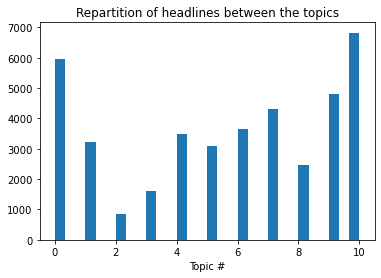

In [260]:
plt.title("Repartition of headlines between the topics")
plt.hist(df_2020_km["km_topic"], bins=30)
plt.xlabel("Topic #")
plt.show()

#### *Observation*:
We can clearly see two new topics:
    - The us elections for topic 4 with the word 'election', 'donald trump', 'biden', 'president'
    - The Covid-19 pandemic for topics 0 and 8 with the word 'coronavirus', 'pandemic', 'lockdown', 'covid19', 'cases'
    
However the modeling didn't detected the topic 'black lives matter' as each word has a meaning seperatly and word2vec have probabily not been trained on this term so don't get the sens of the expression.

## Conclusion 

Both techniques have advantages and disadvantages. It seems than word2vec associated with k-means provide better topics which make more sens for humans, espacially when there is more than 10 topics. However Word2Vec is very sensitive to new expression. For example it didn't get the sens of "Black lives matter". On the other hand as LDA is only working on word association frequency ignoring there sens, it is much more resilient to new words and new expresions.